In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
C = 1.
g_Na = 120.
g_K = 36.
g_L = .3
E_Na = 50.
E_K = -77.
E_L = -54.5
I_ext = 12.

# TODO: as funciton for connections!
I_syn = 0.

tau_d = 3.
tau_r = .1
N = 500.


In [3]:
def alpha_m(V):
    """S5"""
    return .1 * (V + 40.) / (1. - np.exp(-(V + 40.) / 10.))

def beta_m(V):
    """S6"""
    return 4. * np.exp(-(V + 65.) / 18.)

def alpha_h(V):
    """S7"""
    return .07 * np.exp(-(V + 65) / 20.)

def beta_h(V):
    """S8"""
    return 1. / (1 + np.exp(-(V + 35.) / 10.))

def alpha_n(V):
    """S9"""
    return ((V + 55.) / 10.) / (1. - np.exp(-.1 * (V + 55.)))

def beta_n(V):
    """S10"""
    return .125 * np.exp(-(V + 65.) / 80.)
    
def dm(V, m):
    """S2"""
    a = alpha_m(V)
    b = beta_m(V)
    
    return a * (1. - m) - b * m

def dh(V, h):
    """S3"""
    a = alpha_h(V)
    b = beta_h(V)
    
    return a * (1. - h) - b * h

def dn(V, n):
    """S4"""
    a = alpha_n(V)
    b = beta_n(V)
    
    return a * (1. - n) - b * n

def dV(V, m, h, n):
    """S1"""
    return (- g_Na * m ** 3 * h * (V - E_Na) 
            - g_K * n ** 4 * (V - E_K) 
            - g_L * (V - E_L) 
            + I_ext + I_syn ) / C

In [4]:
step_size = .02
t0 = 0.
m0 = .1
h0 = .1
n0 = .1
V0 = - 30.

t_end = 10.

t = np.arange(t0, t_end, step_size)
m = np.zeros(t.size)
m[0] = m0
h = np.zeros(t.size)
h[0] = h0
n = np.zeros(t.size)
n[0] = n0 
V = np.zeros(t.size)
V[0] = V0

In [5]:
for i in range(1, t.size):
    #y_intermediate = y[i-1] + h * y1(t[i-1], y[i-1])
    #y[i] = y[i-1] + (h/2.) * (y1(t[i-1], y[i-1]) + y1(t[i], y_intermediate))
    
    m_i = m[i - 1] + step_size * dm(V[i - 1], m[i - 1])
    m[i] = m[i - 1] + (step_size / 2.) * (dm(V[i - 1], m[i - 1]) + dm(V[i - 1], m_i))
    
    h_i = h[i - 1] + step_size * dh(V[i - 1], h[i - 1])
    h[i] = h[i - 1] + (step_size / 2.) * (dh(V[i - 1], h[i - 1]) + dh(V[i - 1], h_i))

    n_i = n[i - 1] + step_size * dn(V[i - 1], n[i - 1])
    n[i] = n[i - 1] + (step_size / 2.) * (dn(V[i - 1], n[i - 1]) + dn(V[i - 1], n_i))
    
    V_i = V[i - 1] + step_size * dV(V[i - 1], m[i], h[i], n[i])
    V[i] = V[i - 1] + (step_size / 2.) * (dV(V[i - 1], m[i], h[i], n[i]) + dV(V[i - 1], m[i], h[i], n[i]))
    

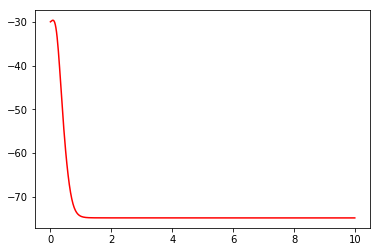

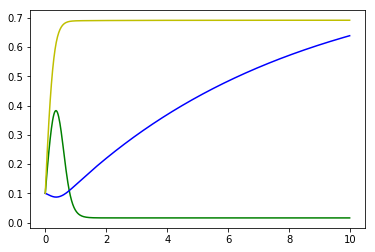

-74.80118499591079
0.01578832579064479
0.638875266485939
0.6917741510381095


In [6]:
plt.plot(t, V, 'r-')
plt.show()
plt.plot(t, m, 'g-')
plt.plot(t, h, 'b-')
plt.plot(t, n, 'y-')
plt.show()
print(V[-1])
print(m[-1])
print(h[-1])
print(n[-1])